# Weather prediction example

This notebook shows a simple way to predict time series data using a PredictLite neural network

(c) Mikko Kursula 2022. MIT License. 

In [1]:
# Enable automatic reloading (if changes are done in the model code)
%load_ext autoreload
%autoreload 2

# General
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data source
import meteostat

# PredictLite
from predictlite.predictlite import PredictLite

### Get weather dataset

In [2]:
# Get hourly weather data
station_id = '02944'
start_dt = datetime(2012, 1, 1)
end_dt = datetime(2022, 1, 1)
dataset = meteostat.Hourly(station_id, start_dt, end_dt).fetch()
dataset.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2012-01-01 00:00:00,-5.5,-5.6,99.0,NaN,NaN,220.0,7.2,NaN,1007.6,NaN,NaN
2012-01-01 01:00:00,-5.2,-5.5,98.0,NaN,NaN,200.0,7.2,NaN,1008.0,NaN,NaN
2012-01-01 02:00:00,-5.2,-5.5,98.0,NaN,NaN,220.0,7.2,NaN,1008.3,NaN,NaN
2012-01-01 03:00:00,-6.0,-6.1,99.0,NaN,NaN,220.0,7.2,NaN,1008.6,NaN,NaN
2012-01-01 04:00:00,-4.6,-5.1,96.0,NaN,NaN,260.0,3.6,NaN,1009.0,NaN,NaN


### Setup and train PredictLite model 

In [3]:
model = PredictLite(
    input_signals=['temp'], 
    input_preprocessing={'temp' : 'z-norm'},
    input_length=48, 
    output_signal='temp',
    output_length=24,
    resample_data=True,
    data_sample_period=3600,
    hidden_layer_n=0,
    train_sample_n=10000,
    test_sample_n=1000,
    epochs=20,
    random_seed=13,
    verbose=True,
)

model.fit(dataset)

Preprocessing done
Training samples created
Testing samples created
Setting up and training the model
epoch:   0, train loss: 0.66151, test loss: 0.27148
epoch:   1, train loss: 0.21057, test loss: 0.17111
epoch:   2, train loss: 0.17358, test loss: 0.15314
epoch:   3, train loss: 0.15663, test loss: 0.13754
epoch:   4, train loss: 0.14201, test loss: 0.12563
epoch:   5, train loss: 0.13117, test loss: 0.11682
epoch:   6, train loss: 0.12296, test loss: 0.11020
epoch:   7, train loss: 0.11752, test loss: 0.10582
epoch:   8, train loss: 0.11307, test loss: 0.10282
epoch:   9, train loss: 0.11021, test loss: 0.10119
epoch:  10, train loss: 0.10802, test loss: 0.09905
epoch:  11, train loss: 0.10641, test loss: 0.09766
epoch:  12, train loss: 0.10544, test loss: 0.09746
epoch:  13, train loss: 0.10462, test loss: 0.09613
epoch:  14, train loss: 0.10368, test loss: 0.09570
epoch:  15, train loss: 0.10275, test loss: 0.09505
epoch:  16, train loss: 0.10210, test loss: 0.09377
epoch:  17, tr

In [4]:
model.model_summary()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=48, out_features=48, bias=True)
  (2): Linear(in_features=48, out_features=24, bias=True)
)


### Make prediction

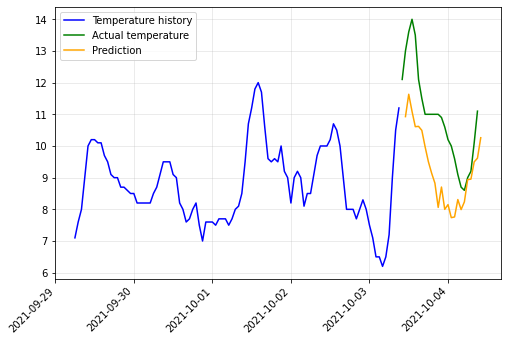

In [5]:
# Datetime for prediction start
prediction_time = datetime(2021, 10, 3, 10)

# Make prediction 
pred = model.predict(dataset, prediction_time)

# Plot data and prediction
ts_idx = dataset.index.get_loc(prediction_time, method='pad')
plt.figure(figsize=(8, 5))
plt.plot(
    dataset.index[ts_idx - 100 : ts_idx].values, 
    dataset.temp[ts_idx - 100 : ts_idx].values, 
    color='blue', 
    label='Temperature history'
)
plt.plot(
    dataset.index[ts_idx : ts_idx + 24].values, 
    dataset.temp[ts_idx : ts_idx + 24].values, 
    color='green',
    label='Actual temperature'
)
plt.plot(
    pred.index.values, 
    pred.temp.values, 
    color='orange', 
    label='Prediction'
)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(alpha=0.3)
plt.show()